In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
data = pd.read_csv('Telecom Churn.csv')
data.shape
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [43]:
data["ch"].value_counts()

churn
False    2850
True      483
Name: count, dtype: int64

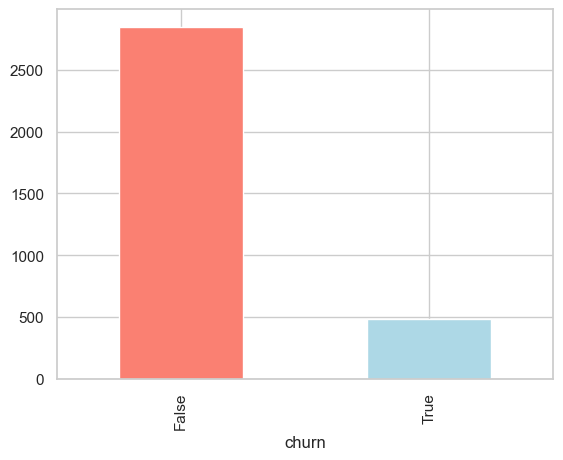

In [44]:
data["churn"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [3]:
data = pd.read_csv('Telecom Churn.csv')

# Check the columns in the dataset
print("Columns in dataset:", data.columns)

# Handle missing values (if any)
print("Missing values in dataset:", data.isnull().sum())

# Drop columns that are not useful for prediction
# 'state', 'phone number' may not contribute to the model, so we can drop them
data.drop(['state', 'phone number'], axis=1, inplace=True)

# Convert 'area code' to categorical as it's not numerical
data['area code'] = data['area code'].astype('category')

# Label Encoding for binary categorical columns
binary_columns = ['international plan', 'voice mail plan', 'churn']
for col in binary_columns:
    if col in data.columns:
        data[col] = LabelEncoder().fit_transform(data[col])

# One-hot encoding for the 'area code' categorical column
data = pd.get_dummies(data, columns=['area code'])

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop('churn', axis=1))
X = pd.DataFrame(scaled_features, columns=data.columns.drop('churn'))
y = data['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Columns in dataset: Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')
Missing values in dataset: state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0

In [4]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2666, 20)
X_test shape: (667, 20)
y_train shape: (2666,)
y_test shape: (667,)


In [ ]:
#changing pattience for 1st one and then maybe hidden units

In [7]:
class MyModule(nn.Module):
    def __init__(self, input_dim=20, hidden_units=200, dropout=0.5):
        super(MyModule, self).__init__()
        self.dense0 = nn.Linear(input_dim, hidden_units)
        self.nonlin = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_units, 1)
    
    def forward(self, X):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        return torch.sigmoid(self.output(X)).squeeze(1)

input_dim = X_train.shape[1]

from skorch.callbacks import EarlyStopping
net = NeuralNetClassifier(
    MyModule,
    module__input_dim=input_dim,
    criterion=torch.nn.BCELoss,
    optimizer=torch.optim.Adam,
    max_epochs=20,  #20 drecreased accuracy
    lr=0.01,    #0.001 lesser accuracy
    callbacks=[
        ('early_stopping', EarlyStopping(patience=5, threshold=0.01))
    ],
)
params = {
    'module__dropout': [0.3,0.5,0.7],                 # Reduce dropout values
    'module__hidden_units': [200],            # Use fewer hidden units
    'lr': [0.001,0.01],                            # Use fewer learning rates
    'max_epochs': [10,20],                       # Limit the epochs
}

# Grid search
gs = GridSearchCV(net, params, refit=True, cv=5, scoring='accuracy')
gs.fit(X_train_np, y_train_np.flatten())

# Print best params and evaluate on test set
print("Best Hyperparameters:", gs.best_params_)
print(f"Test Accuracy: {gs.score(X_test.values.astype(np.float32), y_test.values.astype(np.int64)) * 100:.2f}%")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6529       0.8571        0.5207  0.0994
      2        0.4748       0.8571        0.4206  0.0830
      3        0.4139       0.8571        0.3865  0.0987
      4        0.3848       0.8571        0.3687  0.0677
      5        0.3688       0.8571        0.3556  0.1133
      6        0.3585       0.8571        0.3452  0.0855
      7        0.3461       0.8595        0.3373  0.0841
      8        0.3365       0.8618        0.3311  0.0644
      9        0.3249       0.8665        0.3260  0.0819
     10        0.3164       0.8689        0.3216  0.1011
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6374       0.8571        0.5126  0.0647
      2        0.4721       0.8571        0.4214  0.1015
      3        0.4126       0.8571        0.3893  0.1009
      4        0.3912       0.8

In [8]:
class MyModule(nn.Module):
    def __init__(self, input_dim=20, hidden_units=200, dropout=0.5):
        super(MyModule, self).__init__()
        self.dense0 = nn.Linear(input_dim, hidden_units)
        self.nonlin = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_units, 1)
    
    def forward(self, X):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        return torch.sigmoid(self.output(X)).squeeze(1)

input_dim = X_train.shape[1]

from skorch.callbacks import EarlyStopping
net = NeuralNetClassifier(
    MyModule,
    module__input_dim=input_dim,
    criterion=torch.nn.BCELoss,
    optimizer=torch.optim.Adam,
    max_epochs=20,  #20 drecreased accuracy
    lr=0.01,    #0.001 lesser accuracy
    callbacks=[
        ('early_stopping', EarlyStopping(patience=5, threshold=0.01))
    ],
)
params = {
    'module__dropout': [0.3,0.5,0.7],                 # Reduce dropout values
    'module__hidden_units': [200],            # Use fewer hidden units
    'lr': [0.001,0.01],                            # Use fewer learning rates
    'max_epochs': [10,20],                       # Limit the epochs
}

# Grid search
gs = GridSearchCV(net, params, refit=True, cv=10, scoring='accuracy')
gs.fit(X_train_np, y_train_np.flatten())

# Print best params and evaluate on test set
print("Best Hyperparameters:", gs.best_params_)
print(f"Test Accuracy: {gs.score(X_test.values.astype(np.float32), y_test.values.astype(np.int64)) * 100:.2f}%")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6535       0.8583        0.5338  0.1140
      2        0.4718       0.8562        0.4334  0.1191
      3        0.4102       0.8562        0.3998  0.0970
      4        0.3829       0.8583        0.3809  0.0765
      5        0.3640       0.8583        0.3661  0.0817
      6        0.3538       0.8625        0.3544  0.1045
      7        0.3381       0.8667        0.3449  0.1003
      8        0.3358       0.8667        0.3370  0.1099
      9        0.3224       0.8688        0.3303  0.1010
     10        0.3158       0.8708        0.3244  0.1182
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5690       0.8562        0.4682  0.0959
      2        0.4384       0.8562        0.4031  0.0996
      3        0.3970       0.8562        0.3800  0.1004
      4        0.3758       0.8

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Train XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
xgb_predictions = xgb_model.predict(X_test)

print(xgb_predictions)



[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 

In [18]:
# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Test Accuracy: {xgb_accuracy * 100:.2f}%")

XGBoost Test Accuracy: 96.10%


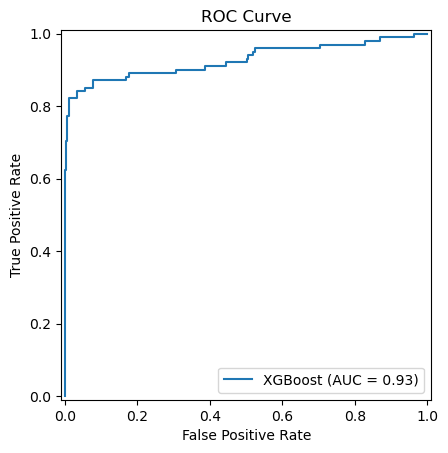

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Predict probabilities for the positive class
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="XGBoost")
roc_display.plot()

# Show plot
plt.title("ROC Curve")
plt.show()


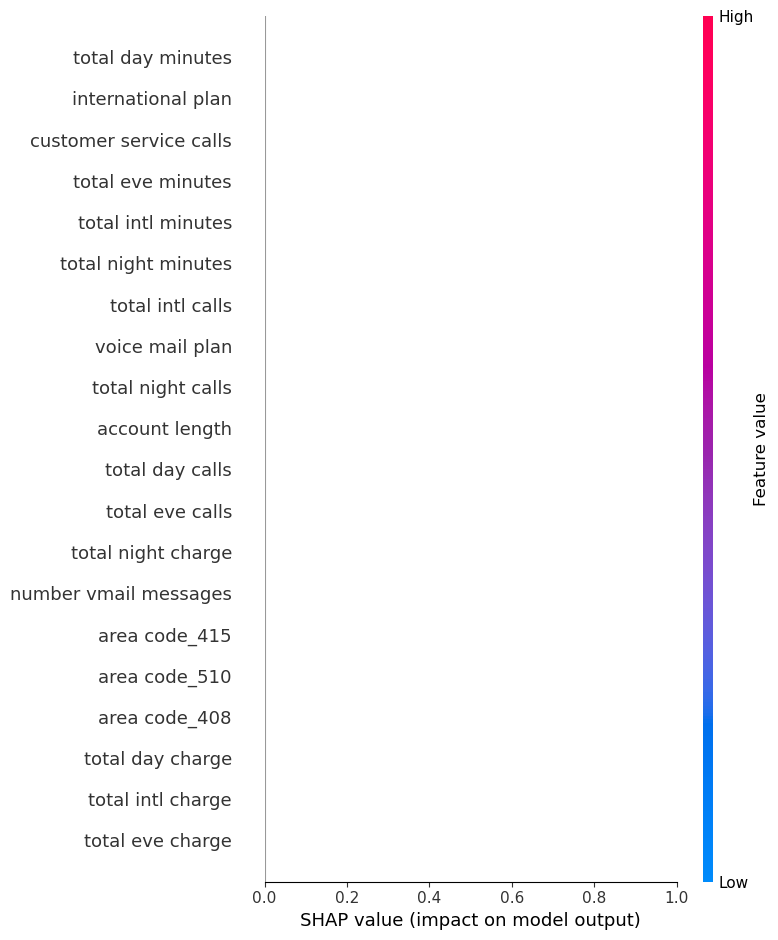

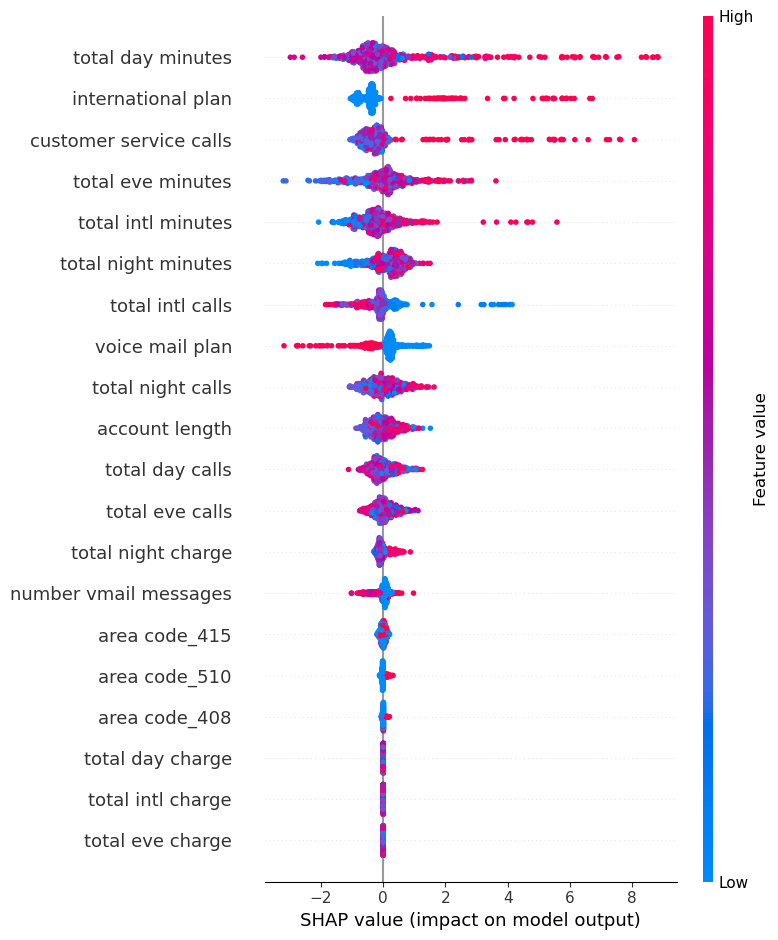

In [22]:
# Explainer and SHAP values
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot (heatmap)
shap.summary_plot(shap_values, X_test, plot_type="heatmap")

# Feature importance plot
shap.summary_plot(shap_values, X_test)


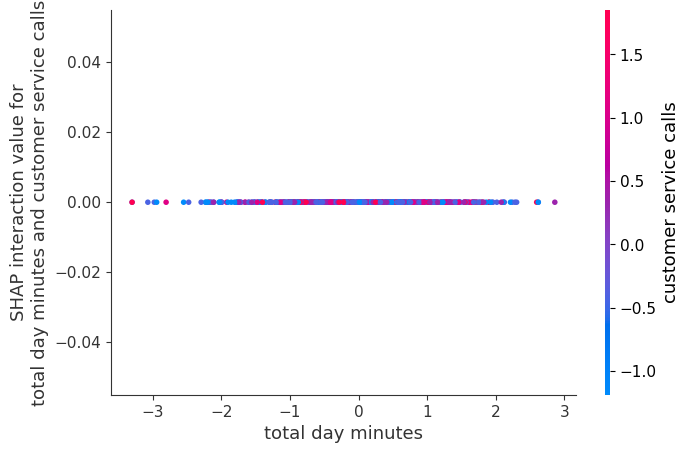

In [23]:
# Calculate SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X_test)

# Plot SHAP interaction values for a pair of features
shap.dependence_plot(("total day minutes", "customer service calls"), shap_interaction_values, X_test)


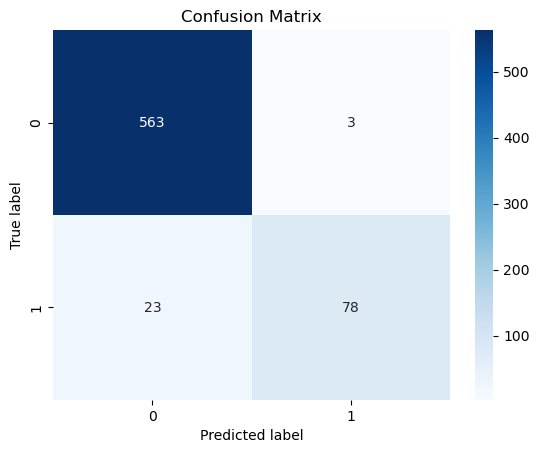

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, xgb_predictions)

# Plot as a heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


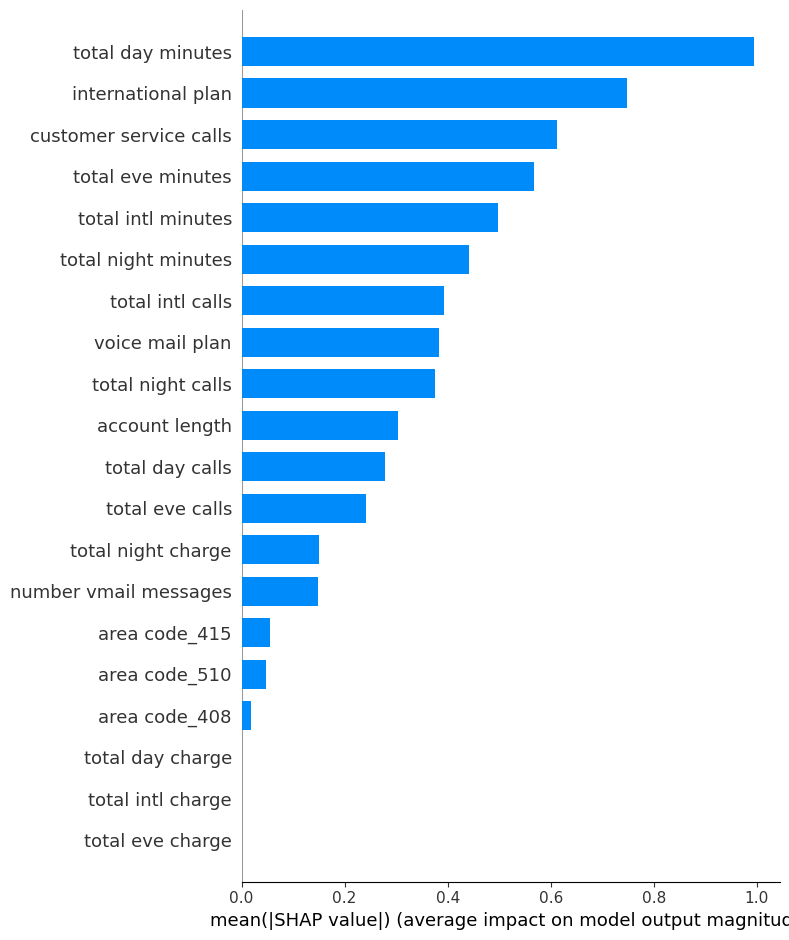

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


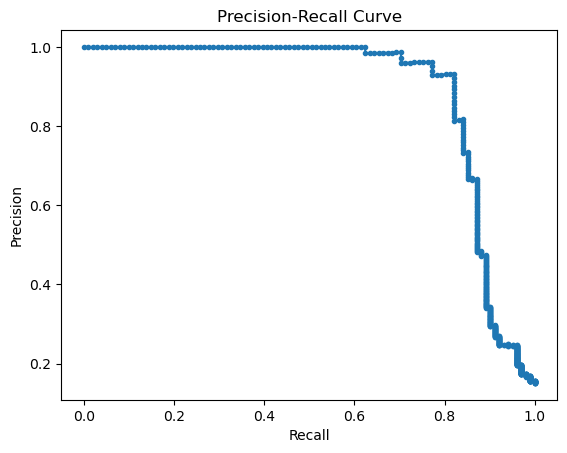

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


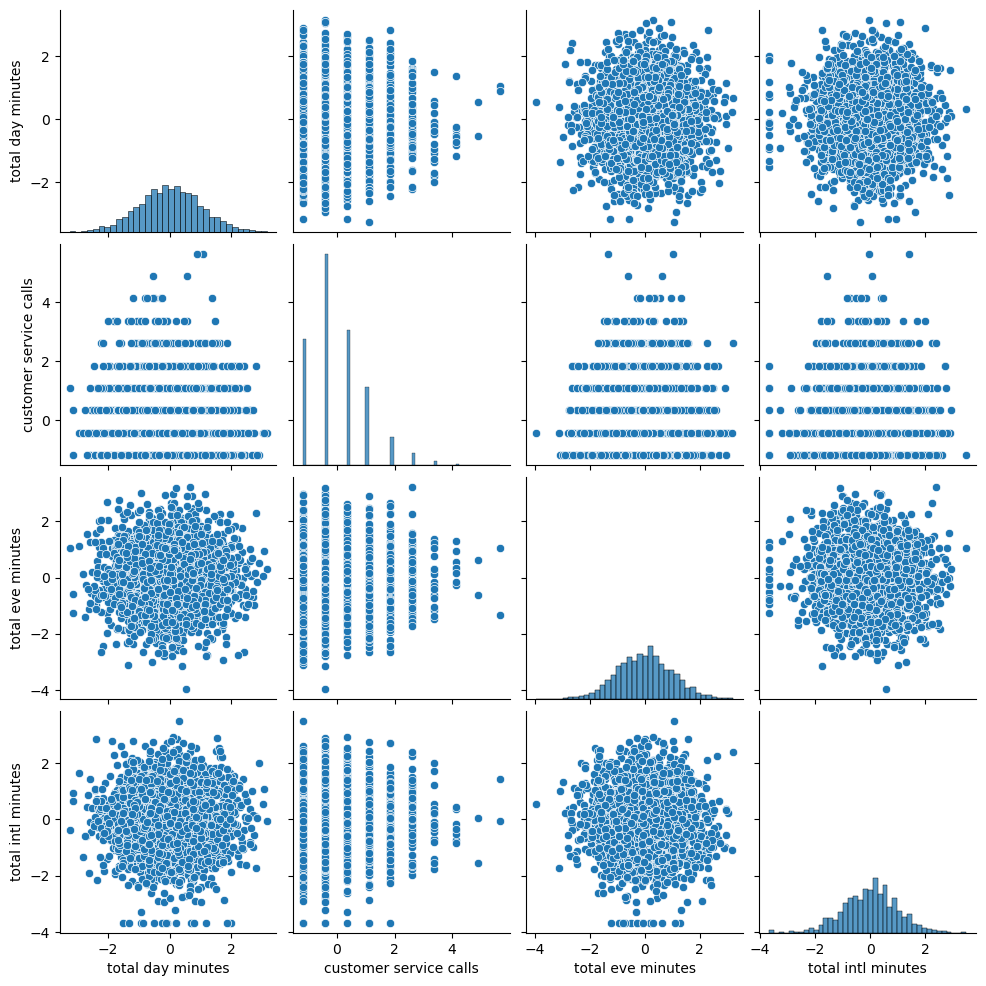

In [34]:
sns.pairplot(X_train[['total day minutes', 'customer service calls', 'total eve minutes', 'total intl minutes']])
plt.show()



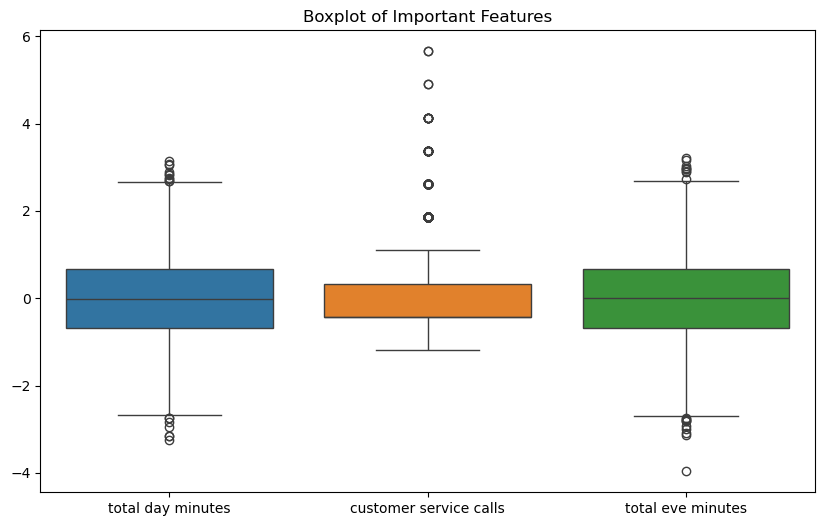

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[['total day minutes', 'customer service calls', 'total eve minutes']])
plt.title('Boxplot of Important Features')
plt.show()
